# Exploring the UTx000 Extension EMA Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

## Self-Report vs Measured Sleep
In this notebook we take a more in-depth look at self-report vs Fitbit-measure sleep metrics.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Data Import
Here we import the morning surveys and the daily Fitbit data

### Morning Sleep Surveys

In [3]:
sr_sleep = pd.read_csv('../data/processed/beiwe-morning_ema-ux_s20.csv',index_col=0,parse_dates=True)
print(f'Length before removing NaNs:\t{len(sr_sleep)}')
for column in ['tst','sol','naw','restful']:
    sr_sleep = sr_sleep[sr_sleep[column].notna()]
print(f'Length after removing NaNs:\t{len(sr_sleep)}')
sr_sleep.head()

Length before removing NaNs:	1682
Length after removing NaNs:	1672


,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful
timestamp,,,,,,,,,,
2020-07-31 09:25:41,hfttkth7,1.0,2.0,1.0,3.0,0.0,6.0,10.0,3.0,0.0
2020-08-19 22:49:04,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,1.0,1.0
2020-08-23 10:58:26,hfttkth7,1.0,1.0,1.0,2.0,0.0,6.0,25.0,0.0,0.0
2020-07-17 09:52:16,hfttkth7,1.0,1.0,0.0,1.0,2.0,7.0,20.0,3.0,2.0
2020-08-12 12:32:54,hfttkth7,1.0,3.0,1.0,2.0,2.0,6.0,20.0,0.0,1.0


### Daily Fitbit Metrics

In [9]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",index_col="date",parse_dates=True,infer_datetime_format=["date","start_time","end_time"])
fb_sleep.head()

,duration_ms,efficiency,end_time,main_sleep,minutes_after_wakeup,minutes_asleep,minutes_awake,minutes_to_sleep,start_time,time_in_bed,beiwe
date,,,,,,,,,,,
2020-05-14,24360000,97,2020-05-14T07:13:00.000,True,0,379,27,0,2020-05-14T00:27:00.000,406,hfttkth7
2020-05-15,29580000,87,2020-05-15T08:06:30.000,True,8,392,101,0,2020-05-14T23:53:30.000,493,hfttkth7
2020-05-16,19740000,95,2020-05-16T04:57:00.000,True,7,287,42,0,2020-05-15T23:28:00.000,329,hfttkth7
2020-05-17,26820000,96,2020-05-17T09:28:30.000,True,8,403,44,0,2020-05-17T02:01:30.000,447,hfttkth7
2020-05-18,24960000,92,2020-05-18T07:20:00.000,True,0,351,65,0,2020-05-18T00:24:00.000,416,hfttkth7


## Data Summary and Comparison
Since both the survey and fitbit-recorded sleep are on the same resolution, we can easily compare their overall statistics.

### Aggregate Comparison
Here we look at the aggregated data across all participants for the two data modalities.

In [10]:
# n
print(f'Number of sleep surveys:\t{len(sr_sleep)}')
print(f'Number of fitbit records:\t{len(fb_sleep)}')

Number of sleep surveys:	1672
Number of fitbit records:	3046


<div class="alert alert-block alert-warning">

There seem to be quite a few records to look at, however we have to see how many nightly records actually overlap. 

- The sleep surveys are indexed by the day that the participant woke up.
- Fitabase data dictionary does not have a record for ```dateOfSleep``` although they do have ```sleepDate```, however these seem to be different variables. Looking at the data, ```dateOfSleep``` seems to correspond to the date of the ```endTime``` label not the ```startTime``` label which Fitabase suggests.

Based on the points above, we just have to check the overlap between the **date of the sleep survey data** and the **date of the fitbit sleep data** per participant to see the combined records that are available.
    
</div>

In [11]:
# creating date column
sr_sleep['date'] = pd.to_datetime(sr_sleep.index.date)
print(type(sr_sleep['date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


First, let's check that we have the same participants for both modalities:

In [13]:
# Pts with fitbits
fb_beiwe = fb_sleep['beiwe'].unique()
# Pts who took surveys
sr_beiwe = sr_sleep['beiwe'].unique()
print(f'Number of Fitbit Participants:\t{len(fb_beiwe)}\nNumber of Survey Participants:\t{len(sr_beiwe)}')


Number of Fitbit Participants:	44
Number of Survey Participants:	50


In [14]:
# list of pts from both
pt_list = np.intersect1d(fb_beiwe,sr_beiwe)
print(f'Length of Intersecting Participants:\t{len(pt_list)}')
print(pt_list)

Length of Intersecting Participants:	40
['15tejjtw' '1a9udoc5' '2xtqkfz1' '43b1cd5m' '4i7679py' '5fvmg226'
 '745vq78e' '7dhu3pn7' '9jtzsuu8' '9xmhtq74' 'axk49ssu' 'e73a1pd5'
 'e8js2jdf' 'eyf8oqwl' 'h8aoiyhv' 'hcpu5myv' 'hfttkth7' 'hxj6brwj'
 'i31pt4b4' 'i4w8dx6l' 'idbkjh8u' 'itmylz3g' 'kyj367pi' 'lkkjddam'
 'mm69prai' 'o6xwrota' 'olaxadz5' 'oxcpr7e3' 'qh34m4r9' 'rnse61g4'
 'rvhdl2la' 't4jphih6' 'tlmlq19s' 'tmexej5v' 'vpy1a985' 'vr9j5rry'
 'xdbdrk6e' 'xlw5ntd5' 'y1tvkx14' 'zdpffrox']


Now we can loop through the participants, combining days of self-report and measured sleep metrics when both records exist. 

In [18]:
combined_sleep = pd.DataFrame() # dataframe to append to
for pt in pt_list:
    sr_sleep_beiwe = sr_sleep[sr_sleep['beiwe'] == pt]
    fb_sleep_beiwe = fb_sleep[fb_sleep['beiwe'] == pt]
    combined_sleep = combined_sleep.append(pd.merge(left=sr_sleep_beiwe,right=fb_sleep_beiwe,left_on='date',right_index=True,how='inner'))
    combined_sleep["beiwe"] = combined_sleep["beiwe_x"]
    combined_sleep.drop(["beiwe_x","beiwe_y"],axis=1,inplace=True)


Now we can see how many nights of data we have from both modalities in addition to if we lost any participants due to lack of overlap.

In [19]:
print(f'Number of overlapping nights: {len(combined_sleep)}')
n = len(combined_sleep['beiwe'].unique())
print(f'\tFrom {n} participants')

Number of overlapping nights: 812
	From 2 participants


So we have just over 600 nights of data, but we lost one participant from lack of overlap. Now we can start to look at the different metrics recorded by both modalities.

#### Total Sleep Time
Total sleep time (TST) in hours

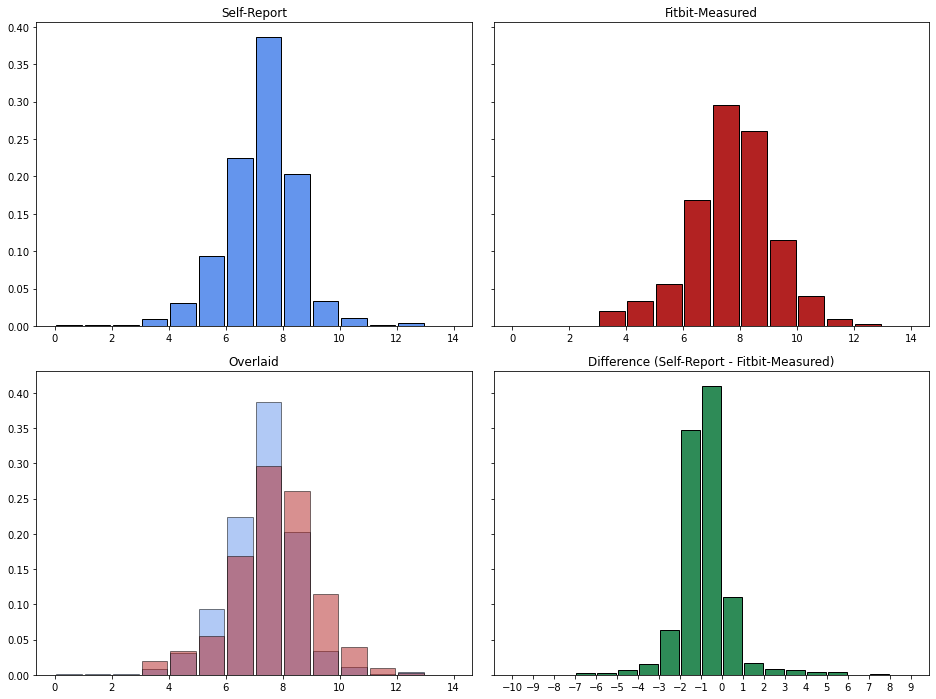

In [22]:
fig, axes = plt.subplots(2,2,figsize=(16,12),sharey='row')
# tst from sr
axes[0,0].hist(combined_sleep['tst'],bins=np.arange(0,15,1),density=True,rwidth=0.9,color='cornflowerblue',edgecolor='black')
axes[0,0].set_title("Self-Report")
# tst from fb
axes[0,1].hist(combined_sleep['duration_ms']/3600000,bins=np.arange(0,15,1),density=True,rwidth=0.9,color='firebrick',edgecolor='black')
axes[0,1].set_title("Fitbit-Measured")
# overlaid
axes[1,0].hist(combined_sleep['tst'],bins=np.arange(0,15,1),density=True,rwidth=0.9,color='cornflowerblue',edgecolor='black',alpha=0.5)
axes[1,0].hist(combined_sleep['duration_ms']/3600000,bins=np.arange(0,15,1),density=True,rwidth=0.9,color='firebrick',edgecolor='black',alpha=0.5)
axes[1,0].set_title("Overlaid")
# difference
n,bins,_ = axes[1,1].hist(combined_sleep['tst']-combined_sleep['duration_ms']/3600000,bins=np.arange(-10,10,1),density=True,rwidth=0.9,color='seagreen',edgecolor='black')
axes[1,1].set_xticks(bins)
axes[1,1].set_title("Difference (Self-Report - Fitbit-Measured)")

plt.subplots_adjust(wspace=0.05,hspace=0.15)
plt.show()
plt.close()

<div class="alert alert-block alert-warning">
    
Results are interesting particularly when analyzing the difference histrogram in the (2,2) location. 

The first result can be interpreted one of two ways:
1. On average, Fitbit **over-estimates** the TST
2. On average, participants **under-estimate** their TST

The second result can again be interpreted one of two ways depending on what we think is the more accurate measure:
1. Fitbit, in some instances, tends to dramatically under-predict TST
2. There are some participants who dramatically over-predict their sleep, or these are simply odd isntances when participants calculated their sleep time incorrectly.

For the second observation, I think the latter point is more valid - that some participants poorly gauged their TST and did not account for the time it took them to fall asleep or instances when the woke in the evening. However, I don't think that explains how the differences could be three or more hours different. **Days with a difference of more than 3(?) hours (absolute value) should be removed from the dataset because, in either case, something is amiss.**

<div class="alert alert-block alert-danger">
What is the best way to deal with TST differences that are so largely negative and/or positive?

We try two methods to remove values of TST that don't agree. We have to start by creating a new variable that is the absolute value of the difference between the two measurements. Then we can do outlier detection on that distribution. 
1. Z-Score: We calculate the z-score of the differences and only use TST values where the z-score is less than 2.5 for the difference
2. IQR: We calculate the IQR for the difference in TST between modalities and remove values that are $1.5*IQR$ greater than the 75% percentile and $1.5*IQR$ less than the 25% percentile.

In [23]:
combined_sleep['TST_Difference'] = combined_sleep['tst'] - combined_sleep['duration_ms']/3600000
combined_sleep['Difference_Z'] = (combined_sleep['TST_Difference'] - np.mean(combined_sleep['TST_Difference'])) / np.std(combined_sleep['TST_Difference'])
reduced_sleep_z = combined_sleep[abs(combined_sleep['Difference_Z']) < 2.5]

iqr = np.percentile(combined_sleep['TST_Difference'],75) - np.percentile(combined_sleep['TST_Difference'],25)
reduced_sleep_iqr = combined_sleep[(combined_sleep['TST_Difference'] < np.percentile(combined_sleep['TST_Difference'],75) + 1.5*iqr) & (combined_sleep['TST_Difference'] > np.percentile(combined_sleep['TST_Difference'],25) - 1.5*iqr)]

print(f'N for Complete Dataset:\t\t\t{len(combined_sleep)}')
print(f'N for Reduced Dataset (z-score):\t{len(reduced_sleep_z)}')
print(f'N for Reduced Dataset (iqr):\t\t{len(reduced_sleep_iqr)}')

N for Complete Dataset:			812
N for Reduced Dataset (z-score):	785
N for Reduced Dataset (iqr):		757


In [24]:
slope_models = []
full_models = []
dataset_labels = ['Complete','Reduced by Z-Score','Reduced by 1.5xIQR']
for df, dataset in zip([combined_sleep,reduced_sleep_z,reduced_sleep_iqr],dataset_labels):
    print(f'OLS for {dataset} Dataset')
    x = df['duration_ms'].values/3600000
    y = df['tst'].values
    # OLS - intercept at origin
    slope_model = sm.OLS(y,x).fit()
    print("\tSlope Model")
    print(f"\t\tParams:\t{slope_model.params}\n\t\tR^2:\t{slope_model.rsquared}")
    slope_models.append(slope_model)
    # OLS - intercept included
    full_model = sm.OLS(y,sm.add_constant(x)).fit()
    print("\tFull Model")
    print(f"\t\tParams:\t{full_model.params}\n\t\tR^2:\t{full_model.rsquared}")
    full_models.append(full_model)

OLS for Complete Dataset
	Slope Model
		Params:	[0.87821941]
		R^2:	0.9743220128701797
	Full Model
		Params:	[2.76436152 0.53240659]
		R^2:	0.38936175932269
OLS for Reduced by Z-Score Dataset
	Slope Model
		Params:	[0.87855243]
		R^2:	0.9872933135326982
	Full Model
		Params:	[1.6174612  0.67661447]
		R^2:	0.6248681281090228
OLS for Reduced by 1.5xIQR Dataset
	Slope Model
		Params:	[0.8808003]
		R^2:	0.9907687497058789
	Full Model
		Params:	[1.15572985 0.73630195]
		R^2:	0.7071689918467716


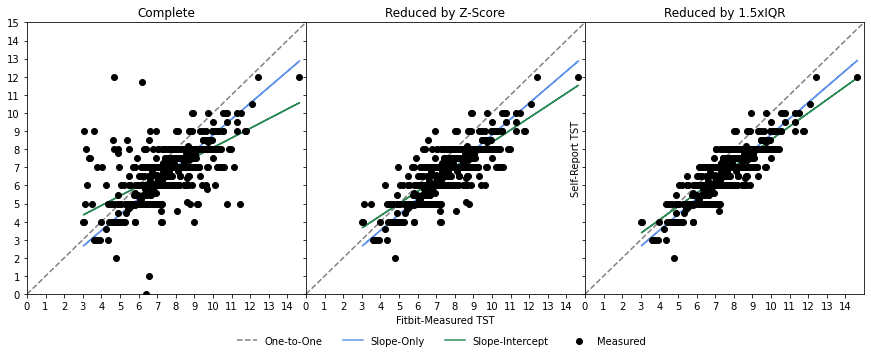

In [25]:
fig, axes = plt.subplots(1,3,figsize=(15,5),sharey='row')
dfs = [combined_sleep,reduced_sleep_z,reduced_sleep_iqr]
for i in range(3):
    ax = axes[i]
    df = dfs[i]
    # data
    ax.scatter(df['duration_ms']/3600000,df['tst'],color='black',zorder=10,label='Measured')
    # one-to-one
    ax.plot([0,15],[0,15],color='gray',linestyle='dashed',zorder=1,label='One-to-One')
    # slope
    ax.plot(df['duration_ms'].values/3600000,slope_models[i].fittedvalues,color='cornflowerblue',label='Slope-Only')
    # full
    ax.plot(df['duration_ms'].values/3600000,full_models[i].fittedvalues,color='seagreen',label='Slope-Intercept')

    ax.set_xlim([0,15])
    ax.set_ylim([0,15])
    ax.set_xticks(np.arange(0,15,1))
    ax.set_yticks(np.arange(0,16,1))
    ax.set_title(dataset_labels[i])
    if i == 1:
        ax.set_xlabel('Fitbit-Measured TST')
    if i == 2:
        ax.legend(bbox_to_anchor=(0.25,-0.12),ncol=4,frameon=False)

ax.set_ylabel('Self-Report TST')
plt.subplots_adjust(wspace=0,hspace=0.15)
plt.show()
plt.close()

### Participant Comparison Across Platforms
Now we look at individual participants and how they compared across the different modalities. With these figures it is important to highlight the individuals if possible. Some ideas include:
- Scatter with color for participants
- m-by-n figure that includes all participants with dots colored and line of best fit included where the other dots are monocolor (I like this one)

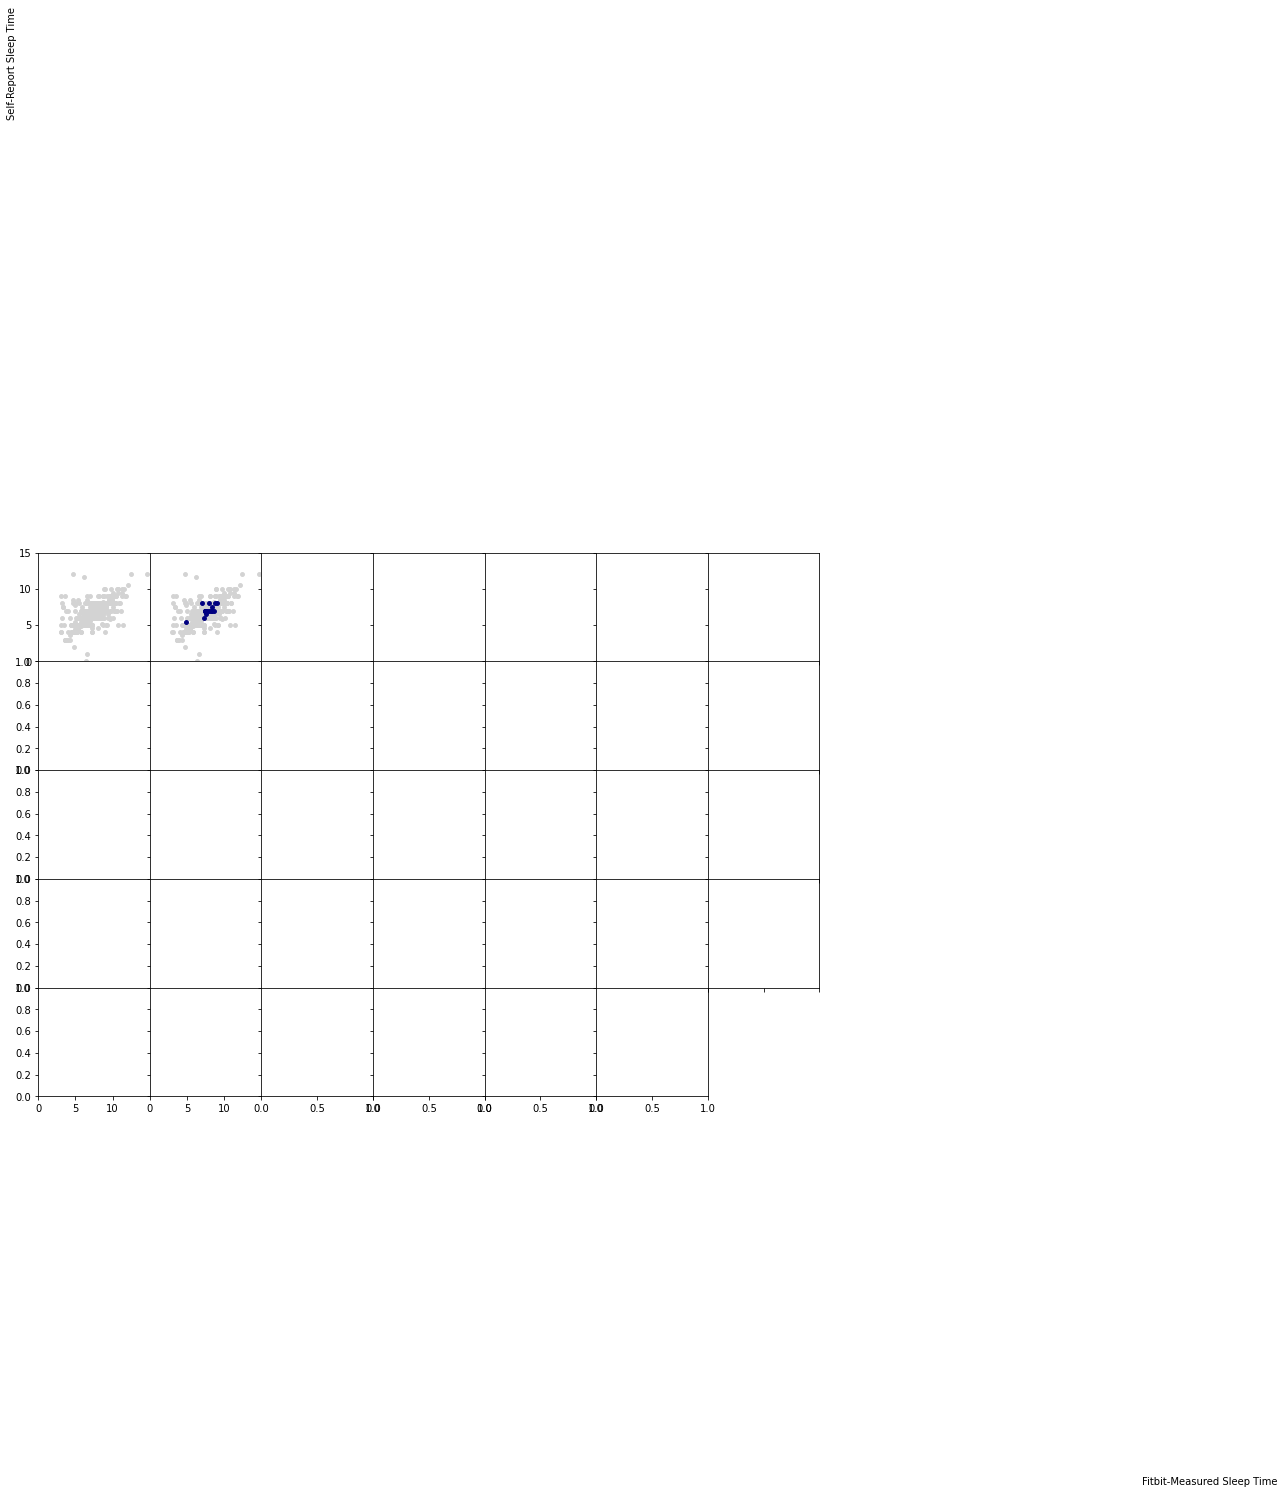

In [26]:
fig, ax = plt.subplots(5,7,figsize=(14,10),sharex='col',sharey='row')
i = 0
rows = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4]
cols = [0,1,2,3,4,5,6]*5
for pt, r, c in zip(combined_sleep['beiwe'].unique(),rows,cols):
    pt_df = combined_sleep[combined_sleep['beiwe'] == pt]
    nonpt_df = combined_sleep[combined_sleep['beiwe'] != pt]
    ax[r,c].scatter(nonpt_df['duration_ms']/3600000,nonpt_df['tst'],s=15,color='lightgray',zorder=1)
    ax[r,c].scatter(pt_df['duration_ms']/3600000,pt_df['tst'],s=15,color='navy',zorder=2)
    ax[r,c].set_xlim([0,15])
    ax[r,c].set_ylim([0,15])
    if r == 0:
        ax[r,c].set_yticks([0,5,10,15])
    else:
        ax[r,c].set_yticks([0,5,10])
        
    if c == 6:
        ax[r,c].set_xticks([0,5,10,15])
    else:
        ax[r,c].set_xticks([0,5,10])
        
    #ax[r,c].text(1,13.75,f'{pt}',ha='left',va='center')
        
    i+=1
ax[2,0].text(-3.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
ax[4,3].text(7.5,-3.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
plt.subplots_adjust(wspace=0,hspace=0)
plt.axis('off')
#plt.savefig('../reports/BuildSys2020/fitbit-beiwe-tst-tst-comprehensive-scatter.pdf')
plt.show()
plt.close()

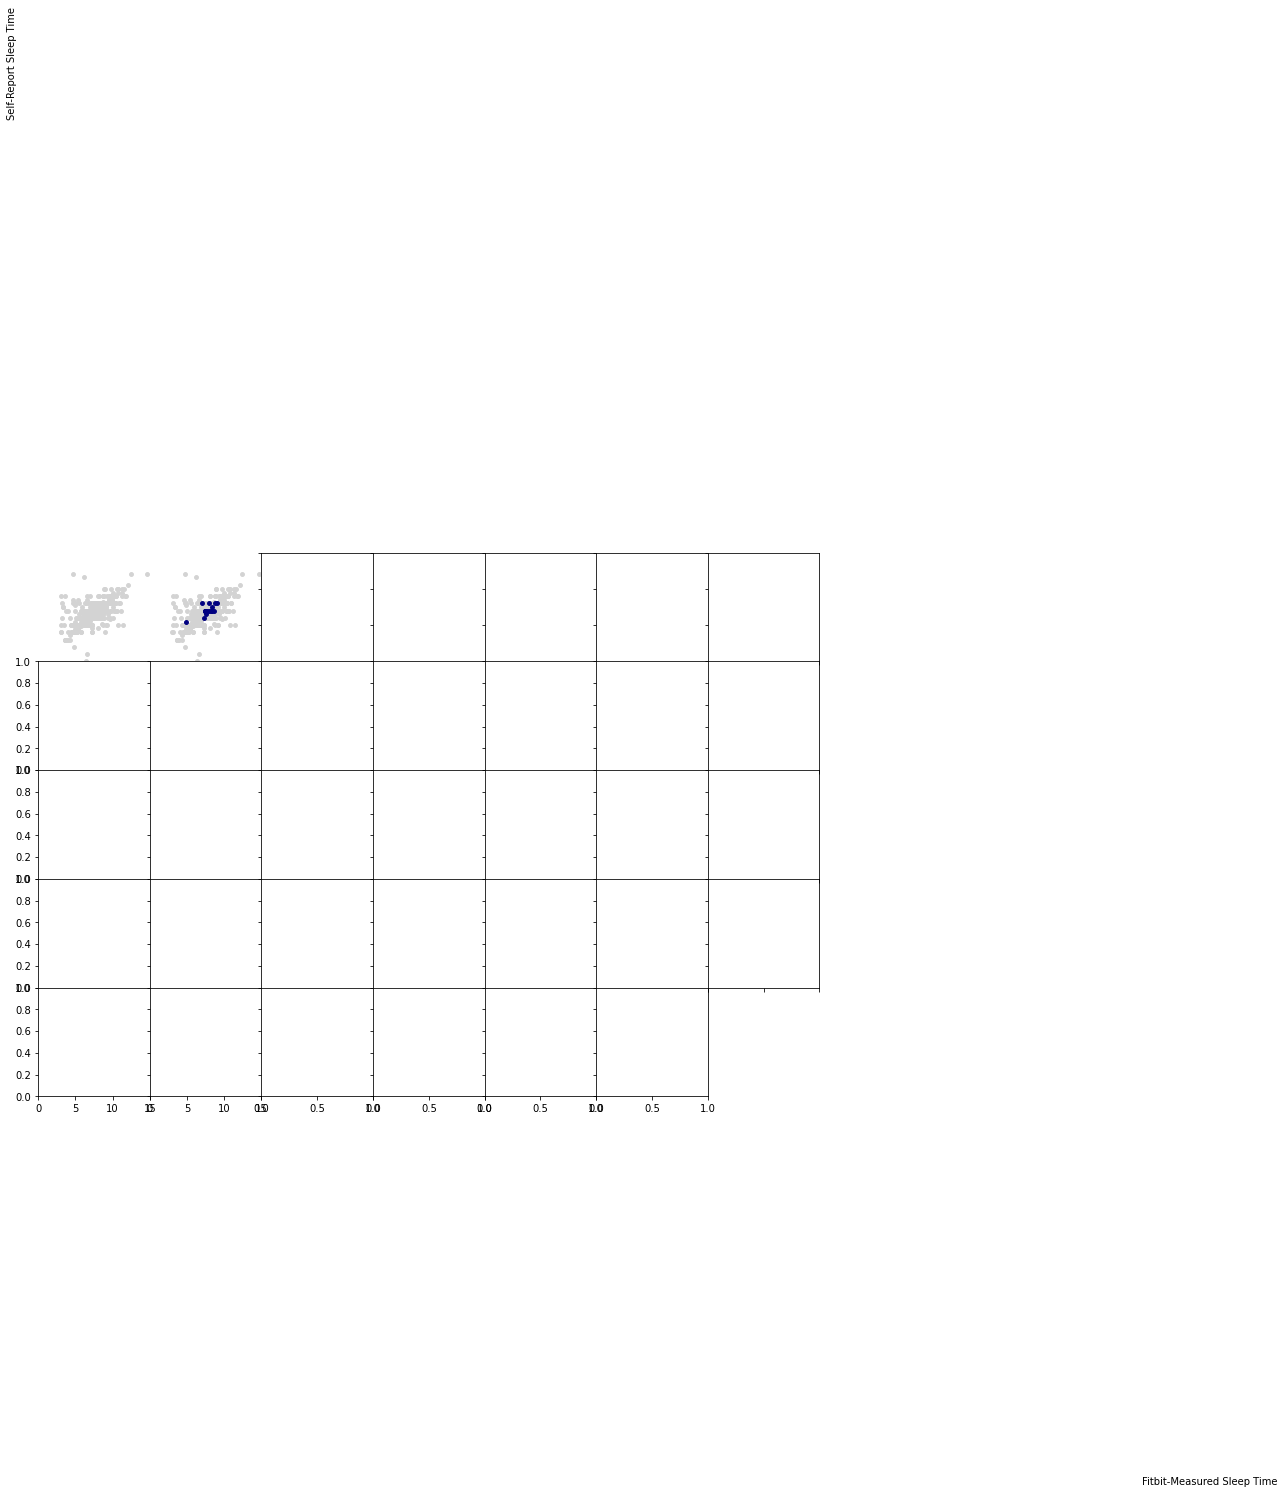

In [27]:
fig, ax = plt.subplots(5,7,figsize=(14,10),sharex='col',sharey='row')
i = 0
rows = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4]
cols = [0,1,2,3,4,5,6]*5
for pt, r, c in zip(combined_sleep['beiwe'].unique(),rows,cols):
    pt_df = combined_sleep[combined_sleep['beiwe'] == pt]
    nonpt_df = combined_sleep[combined_sleep['beiwe'] != pt]
    ax[r,c].scatter(nonpt_df['duration_ms']/3600000,nonpt_df['tst'],s=15,color='lightgray',zorder=1)
    ax[r,c].scatter(pt_df['duration_ms']/3600000,pt_df['tst'],s=15,color='navy',zorder=2)
    ax[r,c].set_xlim([0,15])
    ax[r,c].set_ylim([0,15])
    if r == 4:
        ax[r,c].set_xticks([0,5,10,15])
    else:
        ax[r,c].axis('off')
        
    if c == 0:
        ax[r,c].set_yticks([0,5,10,15])
    else:
        ax[r,c].axis('off')
        
    #ax[r,c].text(1,13.75,f'{pt}',ha='left',va='center')
        
    i+=1
ax[2,0].text(-3.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
ax[4,3].text(7.5,-3.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
plt.subplots_adjust(wspace=0,hspace=0)
#plt.savefig('../reports/conferences/BuildSys_2020/fitbit-beiwe-tst-tst-comprehensive-scatter.pdf')
plt.axis('off')
plt.show()
plt.close()

# Filtered Dataset Analysis
These next cells take a closer look at the sleep metrics from Fitbit and the EMAs for the filtered datasets rather than any night that we have data from both.

In [29]:
ff_sleep = pd.read_csv('../data/processed/fitbit_beiwe_beacon-sleep_summary-ux_s20.csv',
                      index_col=0,parse_dates=True,infer_datetime_format=True)
ff_sleep.columns

Index(['duration_ms', 'efficiency', 'end_time', 'main_sleep',
       'minutes_after_wakeup', 'minutes_asleep', 'minutes_awake',
       'minutes_to_sleep', 'start_time', 'time_in_bed', 'content', 'stress',
       'lonely', 'sad', 'energy', 'tst', 'sol', 'naw', 'restful', 'beiwe',
       'beacon', 'fitbit', 'redcap'],
      dtype='object')

## Aggregate Comparison
We want to see how sleep metrics vary in bulk.

### Bland Altman Difference Plot
See [here](https://www.statsmodels.org/devel/generated/statsmodels.graphics.agreement.mean_diff_plot.html) for some more information.

In [33]:
def plot_bland_altman(df, baseline, alternate, by_var='Beacon'):
    '''
    Plots a difference plot for given vars
    
    Inputs:
    - df: dataframe with columns corresponding to the baseline and alternate measurements
    - baseline: string specifying baseline var
    - alternate: string specifying alternate var
    - by_var: string specifying how to color points
    
    Returns axes of the plot
    '''
    df['mean'] = (df[alternate] + df[baseline])/2
    df['delta'] = df[alternate] - df[baseline]

    fig, ax = plt.subplots(figsize=(12,6))
    sns.scatterplot(data=df, x='mean', y='delta', hue='beacon', palette='coolwarm',
                    legend=None, s=80, alpha=0.8, zorder=10)

    # Mean and CI lines
    u = ff_sleep['delta'].mean()
    ax.axhline(u, color='black', linewidth=0.75)
    ax.text(11,u,f'mean: {round(u,2)}',va='bottom',ha='left')
    
    std = ff_sleep['delta'].std()
    ax.axhline(u+1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u+1.96*std,f'95% CI: {round(u+1.96*std,2)}',va='bottom',ha='left')
    ax.axhline(u-1.96*std, color='black', linewidth=0.75, linestyle='dashed')
    ax.text(11,u-1.96*std,f'95% CI: {round(u-1.96*std,2)}',va='bottom',ha='left')

    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
        
    return ax

Creating plot

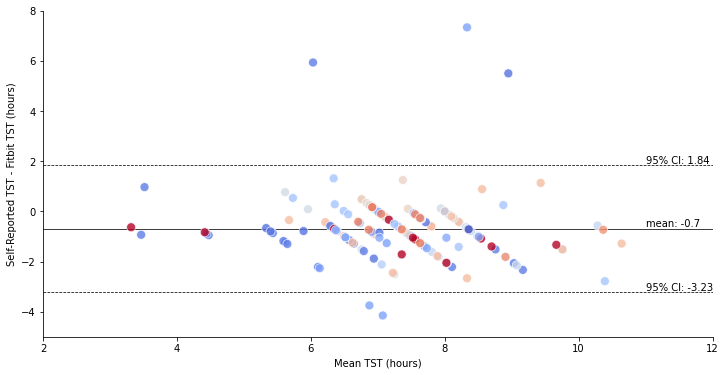

In [34]:
ff_sleep['durationHours'] = ff_sleep['duration_ms']/3600000
ax = plot_bland_altman(ff_sleep, 'durationHours', 'tst')

# Labelling
ax.set_xlabel('Mean TST (hours)')
ax.set_ylabel('Self-Reported TST - Fitbit TST (hours)')
ax.set_xlim([2,12])
ax.set_ylim([-5,8])

plt.savefig('../reports/figures/fitbit-beiwe-tst-tst-bland_altman-ux_s20.pdf',bbox_to_anchor='tight')
plt.show()
plt.close()

## Participant Comparison
We want to show how the participant sleep metric measurements vary across devices

### Scatter Plot - Participant versus the Study
Similar to the scatter plots shown above, but with a different dataset. 

In [35]:
def scatter_tst_comparison(df, by_var='beacon', save=False, save_dir='../reports/figures/'):
    '''
    Creates a scatter plot with participant level data over aggregate data
    
    Inputs:
    - df: dataframe with Fitbit and EMA sleep metrics
    - by_var: variable to separate by
    
    Returns void
    '''
    df_to_plot = pd.DataFrame()
    for pt in df[by_var].unique():
        df_pt = df[df[by_var] == pt]
        df_pt['count'] = len(df_pt)
        df_to_plot = df_to_plot.append(df_pt)
        
    df_to_plot.sort_values('count',inplace=True)
    
    fig, ax = plt.subplots(3,6,figsize=(14,7),sharex='col',sharey='row')
    i = 0
    rows = [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2]
    cols = [0,1,2,3,4,5]*3
    for pt, r, c in zip(df_to_plot[by_var].unique(),rows,cols):
        pt_df = df_to_plot[df_to_plot[by_var] == pt]
        nonpt_df = df_to_plot[df_to_plot[by_var] != pt]
        ax[r,c].scatter(nonpt_df['duration_ms']/3600000,nonpt_df['tst'],s=15,color='lightgray',zorder=1)
        ax[r,c].scatter(pt_df['duration_ms']/3600000,pt_df['tst'],s=15,color='navy',zorder=2)
        ax[r,c].set_xlim([0,15])
        ax[r,c].set_ylim([0,15])
        ax[r,c].set_title(pt)
        if r == max(rows) and c == min(cols):
            ax[r,c].set_xticks([0,5,10,15])
            ax[r,c].set_yticks([0,5,10,15])
            for loc in ['right','top']:
                ax[r,c].spines[loc].set_visible(False)
        else:
            ax[r,c].axis('off')

        i+=1
    ax[1,0].text(-2.5,7.5,'Self-Report Sleep Time',rotation=90,ha='center',va='center')
    ax[2,3].text(0,-2.5,'Fitbit-Measured Sleep Time',ha='center',va='top')
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.axis('off')
    if save:
        plt.savefig(f'{save_dir}fitbit-beiwe-tst-tst-scatter-ux_s20.pdf',bbox_to_anchor='tight')
        
    plt.show()
    plt.close()

Now creating the scatterplot

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


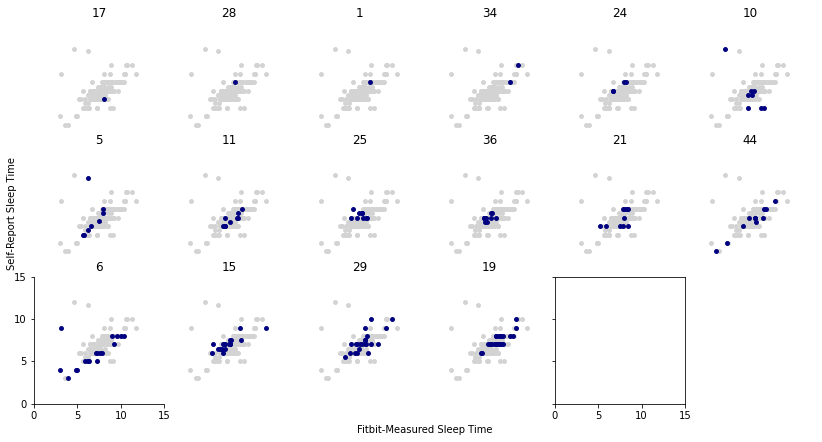

In [36]:
scatter_tst_comparison(ff_sleep)